In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time
import sys 

In [2]:
# data loading
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
pro_ex = pd.read_csv('promotional_expense.csv')
hol_details = pd.read_excel('holidays.xlsx')

In [3]:
# Making train data on Month level
trainee = train.groupby(['Year','Month','Product_ID','Country']).Sales.sum().reset_index()

<h2>Expenses Info</h2>

In [4]:
# Assuming Product Type equal to Product_ID
# Converting Product_Type to Product_ID
pro_ex.columns = ['Year','Month','Country','Product_ID','Expense_Price']

In [5]:
# Merging with expenses
train_d = trainee.merge(pro_ex,how = 'left',on = ['Year','Month','Product_ID','Country'])
test_d = test.merge(pro_ex,how = 'left',on = ['Year','Month','Product_ID','Country'])

In [6]:
train_d[(train_d['Country'] == 'Argentina') & (train_d['Month'] == 1)]

,Year,Month,Product_ID,Country,Sales,Expense_Price
0,2013,1,1,Argentina,34346025.00,14749.307
2,2013,1,2,Argentina,2751851.48,1329.374
108,2014,1,1,Argentina,44600850.00,15316.880
110,2014,1,2,Argentina,4821701.64,2218.769
220,2015,1,1,Argentina,46580625.00,16242.659
222,2015,1,2,Argentina,5899549.88,2612.940
226,2015,1,3,Argentina,126000.00,NaN
346,2016,1,1,Argentina,14740425.00,10215.226
348,2016,1,2,Argentina,7535399.20,3274.259
352,2016,1,3,Argentina,17375400.00,NaN


So it is simply clear that Expenses for product_ID 3 is not given. so we need to impute missing values.

In [7]:
# Impute Mean of expenses in particular month of particular country in place of missing values
info = train_d.groupby(['Country','Month']).Expense_Price.mean().reset_index()

# Dealing with missing values
info_train = train_d.merge(info,how = 'left',on = ['Month','Country'])
model = info_train['Expense_Price_x'].isnull()
info_train.loc[model,'Expense_Price_x'] = info_train.loc[model,'Expense_Price_y']

info_test = test_d.merge(info,how = 'left',on = ['Month','Country'])
model = info_test['Expense_Price_x'].isnull()
info_test.loc[model,'Expense_Price_x'] = info_test.loc[model,'Expense_Price_y']

In [8]:
# dropping y_component of Expenses
info_train.drop(['Expense_Price_y'],axis = 1,inplace = True)
info_test.drop(['Expense_Price_y'],axis = 1,inplace = True)

<h2>Holidays Info</h2>

In [9]:
# Extracting Year from DATE
hol_details['Year'] = hol_details['Date'].str.split(expand = True)[0].str[0:4]

# Extracting Month from DATE
hol_details['Month'] = hol_details['Date'].str.split(expand = True)[1].str[:-1]

# Making new feature to determine the number of holidays per Month in respective countries
hol_details = hol_details.groupby(['Country','Year','Month']).Date.agg('count').reset_index()

# Renaming Columns
hol_details.columns = ['Country', 'Year', 'Month', 'No_of_holidays']

In [10]:
# Merging hol_details
hol_details['Year'] = hol_details['Year'].astype('int64')
hol_details['Month'] = hol_details['Month'].astype('int64')

info_train = info_train.merge(hol_details,how = 'left',on = ['Country','Year','Month'])
# Imputing zero in place of missing value assuming no holidays in these months
info_train.fillna(0,inplace = True)

info_test = info_test.merge(hol_details,how = 'left',on = ['Country','Year','Month'])
# Imputing zero in place of missing value assuming no holidays in these months
info_test.fillna(0,inplace = True)

In [11]:
info_train.sort_values(['Country','Product_ID'],inplace = True)

<h1>Visualization</h1>

In [12]:
info_train.corr()

,Year,Month,Product_ID,Sales,Expense_Price_x,No_of_holidays
Year,1.000000,-0.125730,-0.020647,0.024104,0.050131,0.090912
Month,-0.125730,1.000000,0.014924,0.010762,0.011035,-0.096847
Product_ID,-0.020647,0.014924,1.000000,-0.196632,-0.261317,-0.198979
Sales,0.024104,0.010762,-0.196632,1.000000,0.973985,-0.029045
Expense_Price_x,0.050131,0.011035,-0.261317,0.973985,1.000000,-0.021206
No_of_holidays,0.090912,-0.096847,-0.198979,-0.029045,-0.021206,1.000000


Text(0,0.5,'Sales')

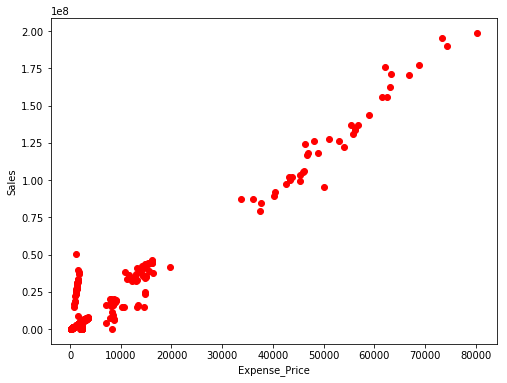

In [13]:
plt.figure(figsize=(8,6))
plt.plot(info_train['Expense_Price_x'],info_train['Sales'],'ro')
plt.xlabel('Expense_Price')
plt.ylabel('Sales')

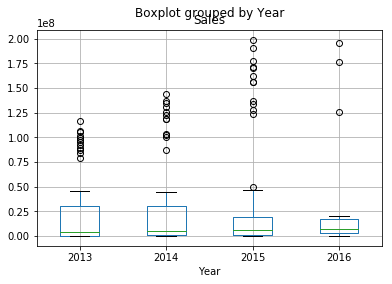

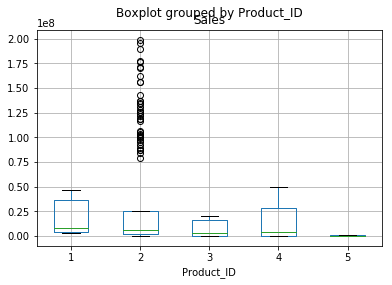

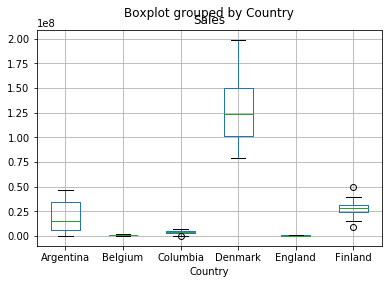

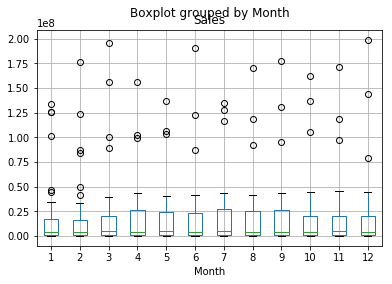

In [14]:
# This would not be very fruitfull as Sales of all countries are given in local currency
info_train.boxplot(column='Sales', by = 'Year')
info_train.boxplot(column='Sales', by = 'Product_ID')
info_train.boxplot(column='Sales', by = 'Country')
info_train.boxplot(column='Sales', by = 'Month')

In [15]:
temp = info_train.pivot_table(values = 'Sales', columns= 'Product_ID', index='Country', aggfunc= 'sum')

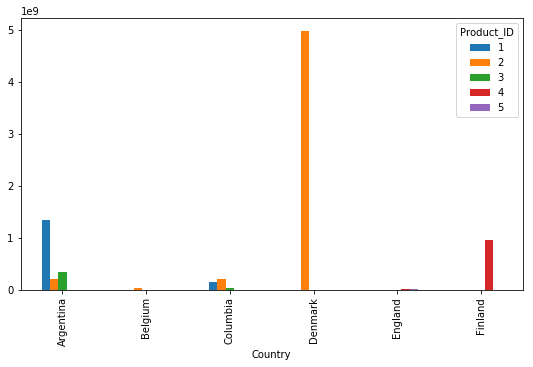

In [16]:
temp.plot(kind = 'bar',figsize=(9,5), sharey = True)

So Argentina and Columbia dealt with Product_ID - 1,2,3 & Belgium and Denmark dealt with Product_ID - 2 & England - 4,5 & Finland - 4

In [17]:
# As we have Sales data of countries in their respective countries so it's better to visualize them independently
# splitting train and test data on the basis of countries
train_ar = info_train[info_train['Country'] == 'Argentina']
train_be = info_train[info_train['Country'] == 'Belgium']
train_co = info_train[info_train['Country'] == 'Columbia']
train_de = info_train[info_train['Country'] == 'Denmark']
train_en = info_train[info_train['Country'] == 'England']
train_fi = info_train[info_train['Country'] == 'Finland']

test_ar = info_test[info_test['Country'] == 'Argentina']
test_be = info_test[info_test['Country'] == 'Belgium']
test_co = info_test[info_test['Country'] == 'Columbia']
test_de = info_test[info_test['Country'] == 'Denmark']
test_en = info_test[info_test['Country'] == 'England']
test_fi = info_test[info_test['Country'] == 'Finland']

In [18]:
info_train['Country'].unique()

array(['Argentina', 'Belgium', 'Columbia', 'Denmark', 'England',
       'Finland'], dtype=object)

Argentina


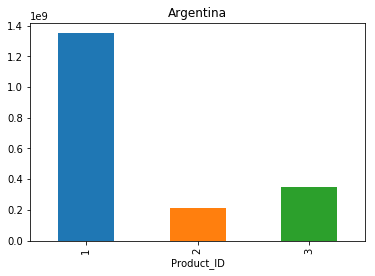

Belgium


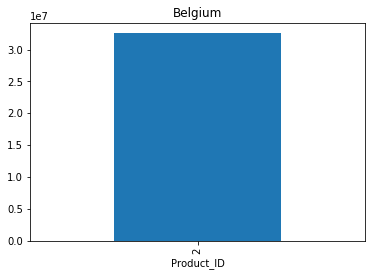

Columbia


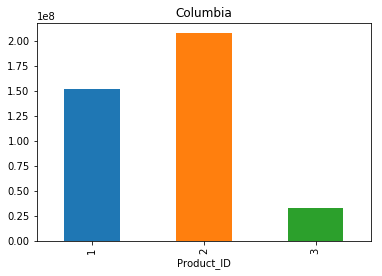

Denmark


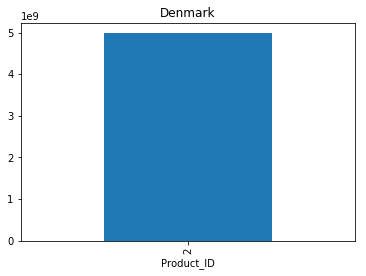

England


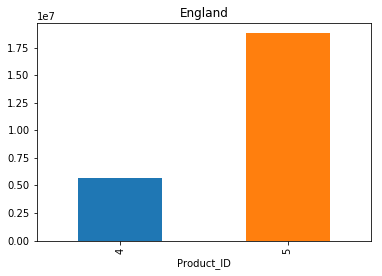

Finland


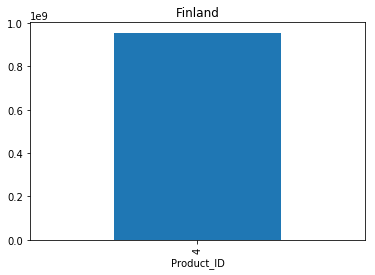

In [19]:
for i,j in zip([train_ar,train_be,train_co,train_de,train_en,train_fi],['Argentina', 'Belgium', 'Columbia', 'Denmark', 'England','Finland']):
    print(j)
    i.groupby(['Product_ID']).Sales.sum().plot(kind='bar')
    plt.title(j)
    plt.show()

In [20]:
for i,j in zip([train_ar,train_be,train_co,train_de,train_en,train_fi],[test_ar,test_be,test_co,test_de,test_en,test_fi]):
    i['Date'] = i['Year'].astype(str)+'-'+ i['Month'].astype(str)
    j['Date'] = j['Year'].astype(str)+'-'+ j['Month'].astype(str)

C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# Breaking out data on the basis of product_Id
train_ar_1 = train_ar[train_ar['Product_ID'] == 1]
train_ar_2 = train_ar[train_ar['Product_ID'] == 2]
train_ar_3 = train_ar[train_ar['Product_ID'] == 3]
train_co_1 = train_co[train_co['Product_ID'] == 1]
train_co_2 = train_co[train_co['Product_ID'] == 2]
train_co_3 = train_co[train_co['Product_ID'] == 3]
train_en_4 = train_en[train_en['Product_ID'] == 4]
train_en_5 = train_en[train_en['Product_ID'] == 5]
train_be_2 = train_be[train_be['Product_ID'] == 2]
train_de_2 = train_de[train_de['Product_ID'] == 2]
train_fi_4 = train_fi[train_fi['Product_ID'] == 4]

In [22]:
# Breaking out data on the basis of product_Id
test_ar_1 = test_ar[test_ar['Product_ID'] == 1]
test_ar_2 = test_ar[test_ar['Product_ID'] == 2]
test_ar_3 = test_ar[test_ar['Product_ID'] == 3]
test_co_1 = test_co[test_co['Product_ID'] == 1]
test_co_2 = test_co[test_co['Product_ID'] == 2]
test_co_3 = test_co[test_co['Product_ID'] == 3]
test_en_4 = test_en[test_en['Product_ID'] == 4]
test_en_5 = test_en[test_en['Product_ID'] == 5]
test_be_2 = test_be[test_be['Product_ID'] == 2]
test_de_2 = test_de[test_de['Product_ID'] == 2]
test_fi_4 = test_fi[test_fi['Product_ID'] == 4]

In [23]:
for i,j in zip([train_ar_1,train_ar_2,train_ar_3,train_be_2,train_co_1,train_co_2,train_co_3,train_de_2,train_en_4,train_en_5,train_fi_4],[test_ar_1,test_ar_2,test_ar_3,test_be_2,test_co_1,test_co_2,test_co_3,test_de_2,test_en_4,test_en_5,test_fi_4]):
    print(i.shape,j.shape)

(39, 8) (12, 9)
(39, 8) (12, 9)
(24, 8) (3, 9)
(39, 8) (12, 9)
(39, 8) (12, 9)
(39, 8) (12, 9)
(28, 8) (3, 9)
(39, 8) (12, 9)
(34, 8) (9, 9)
(34, 8) (9, 9)
(34, 8) (9, 9)


train_ar_1


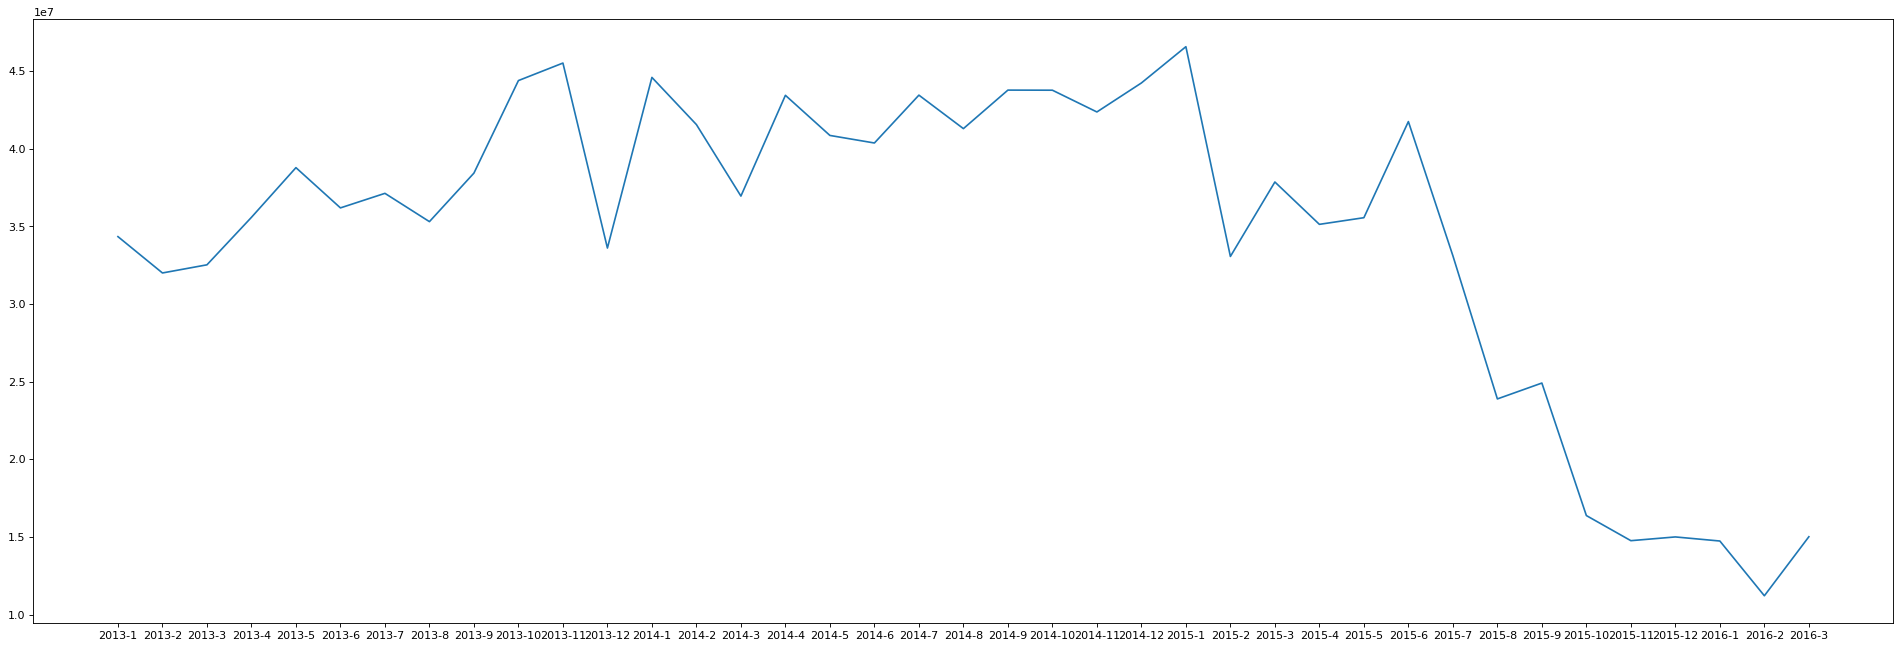

train_ar_2


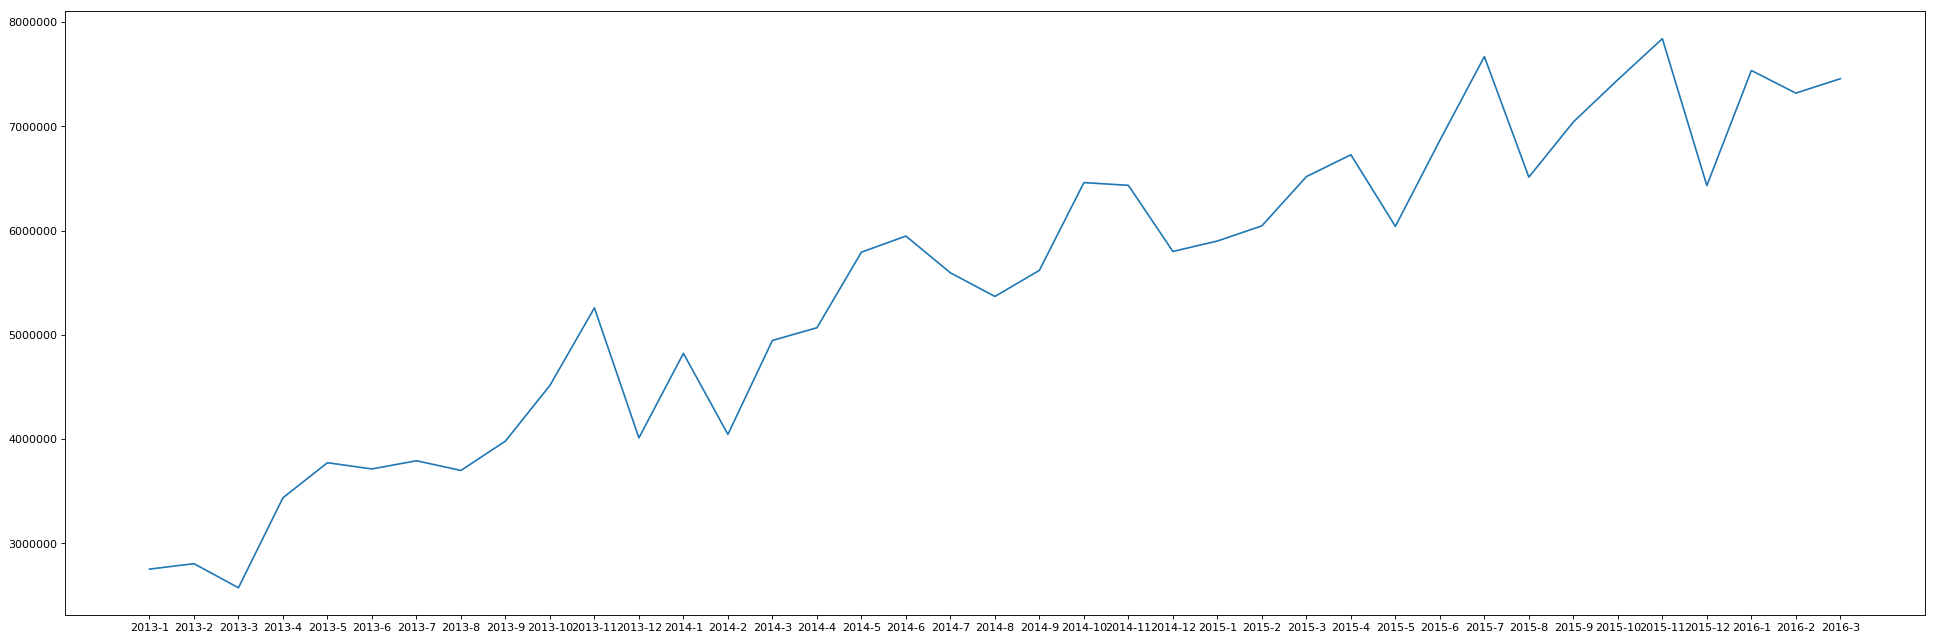

train_ar_3


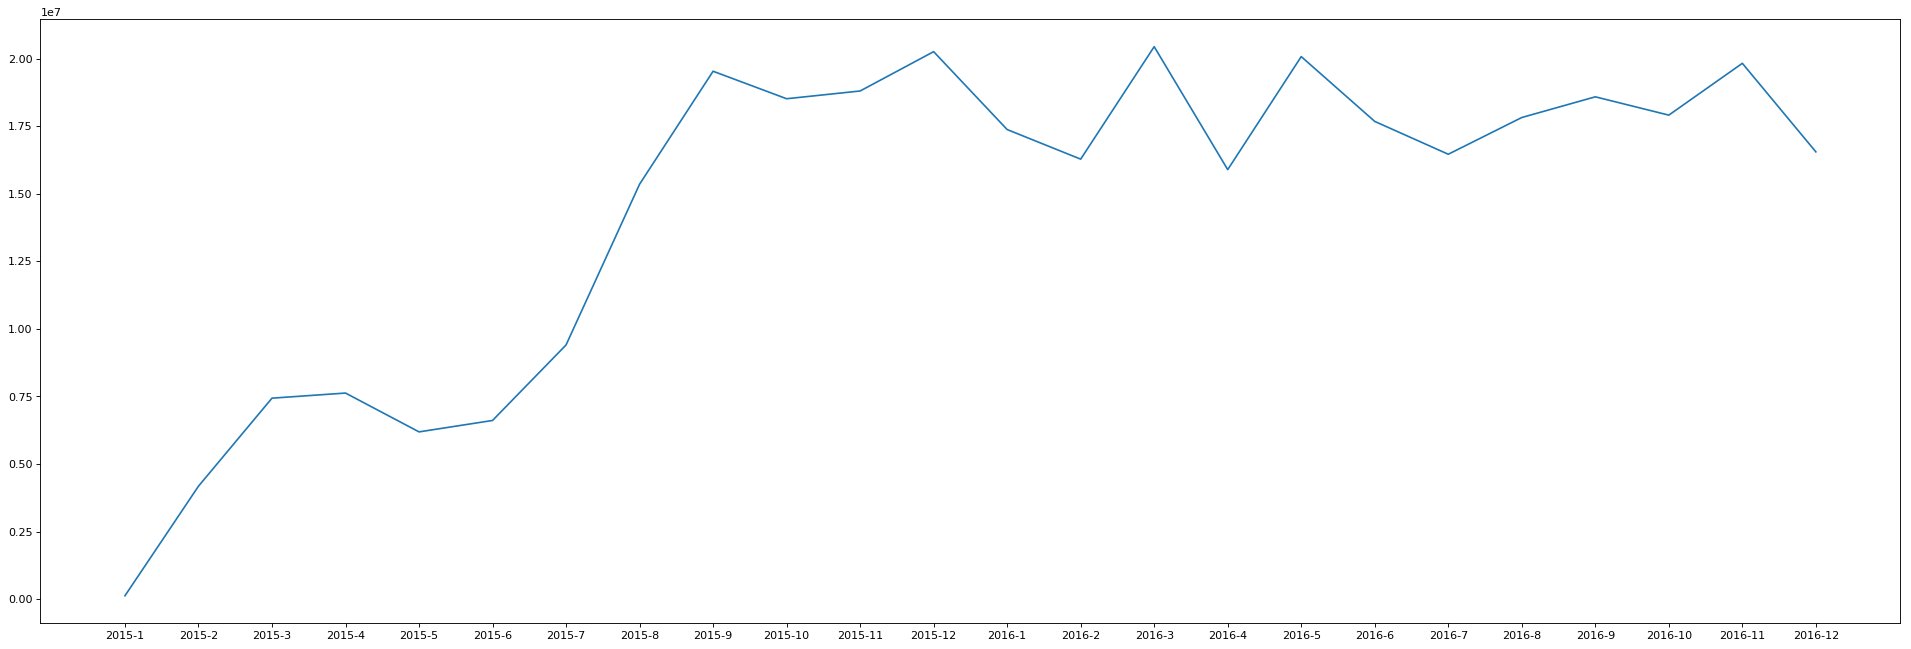

train_co_1


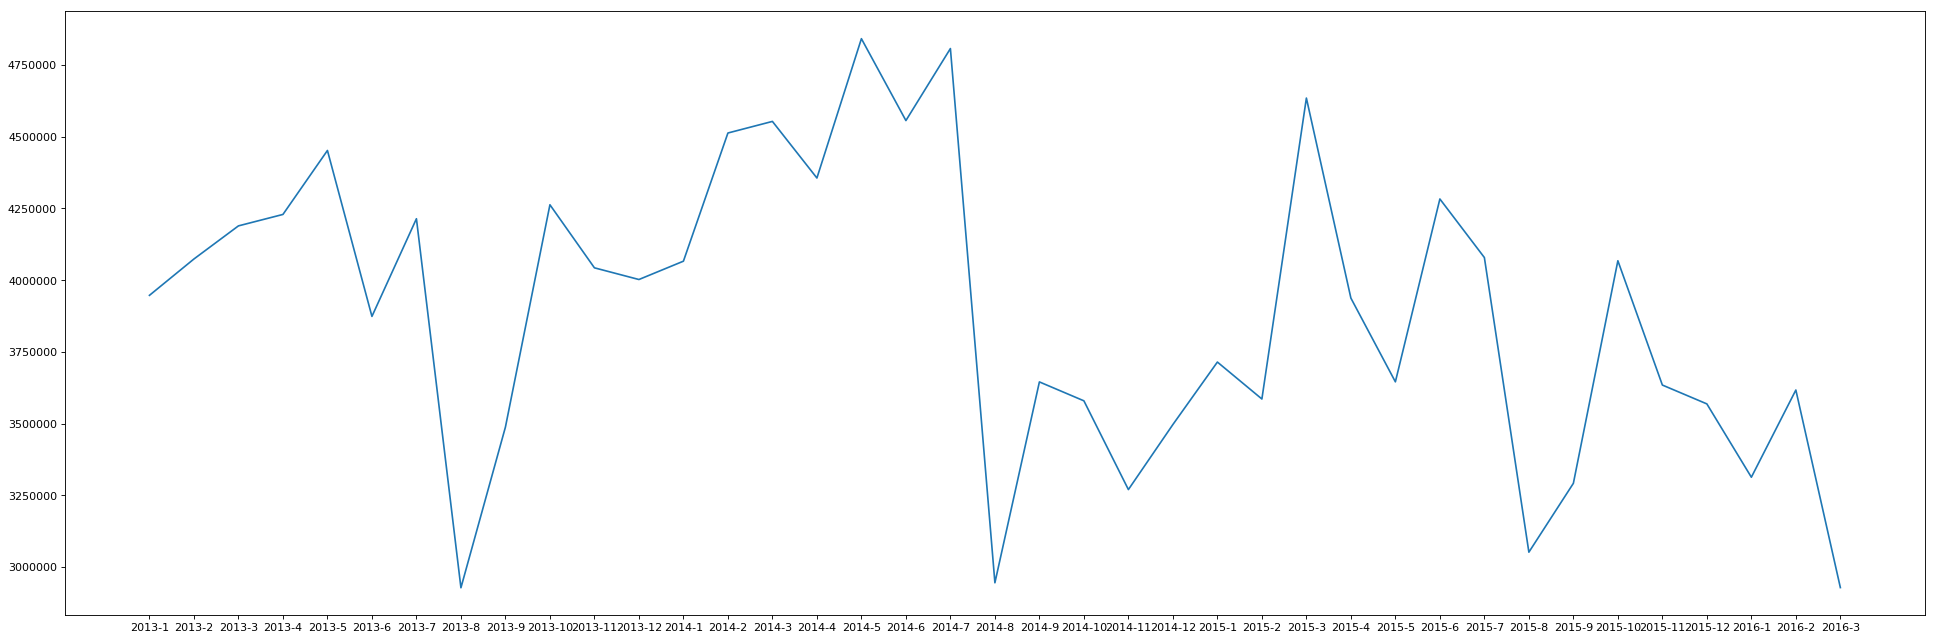

train_co_2


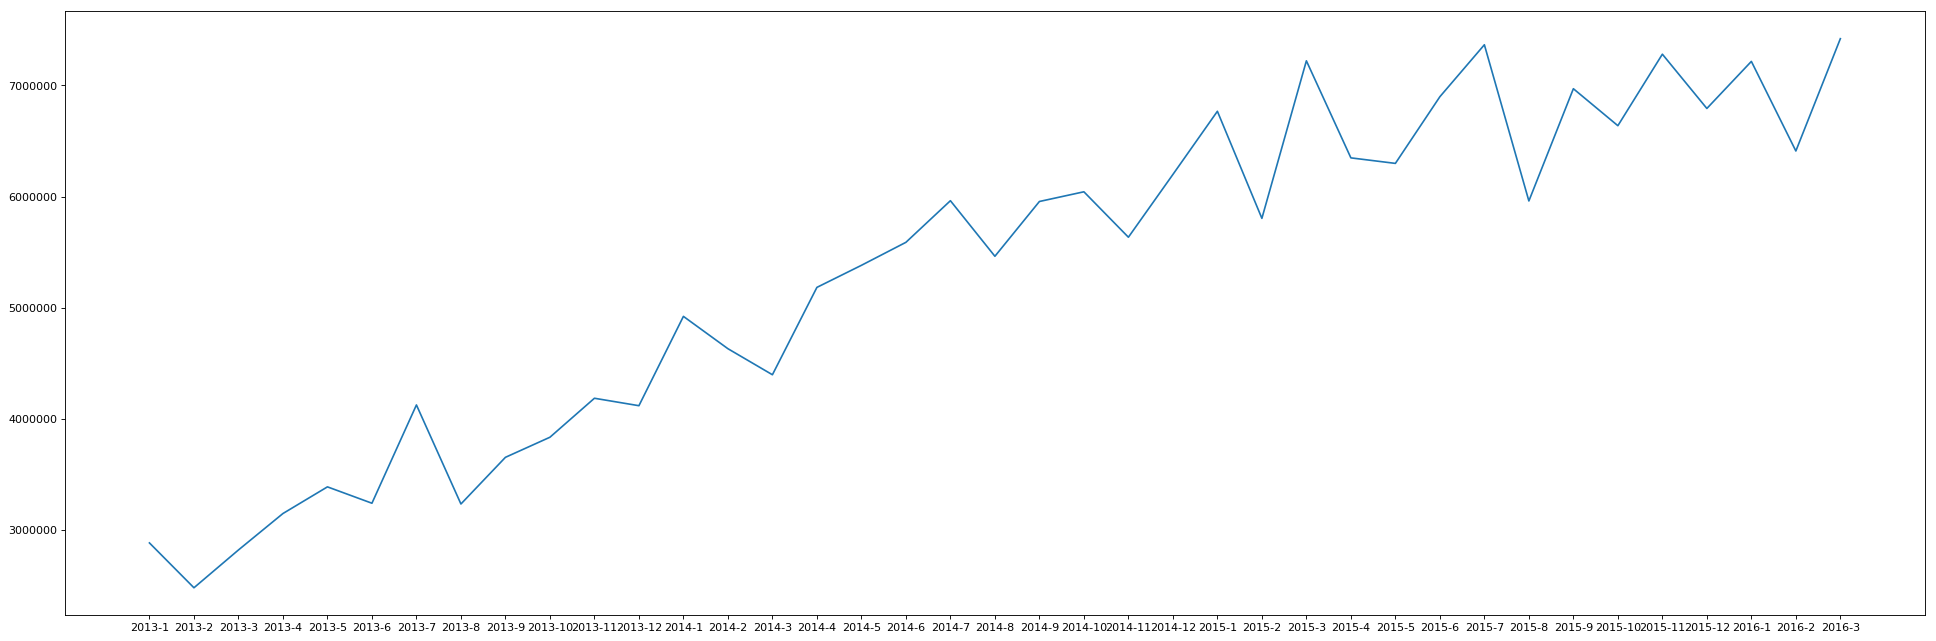

train_co_3


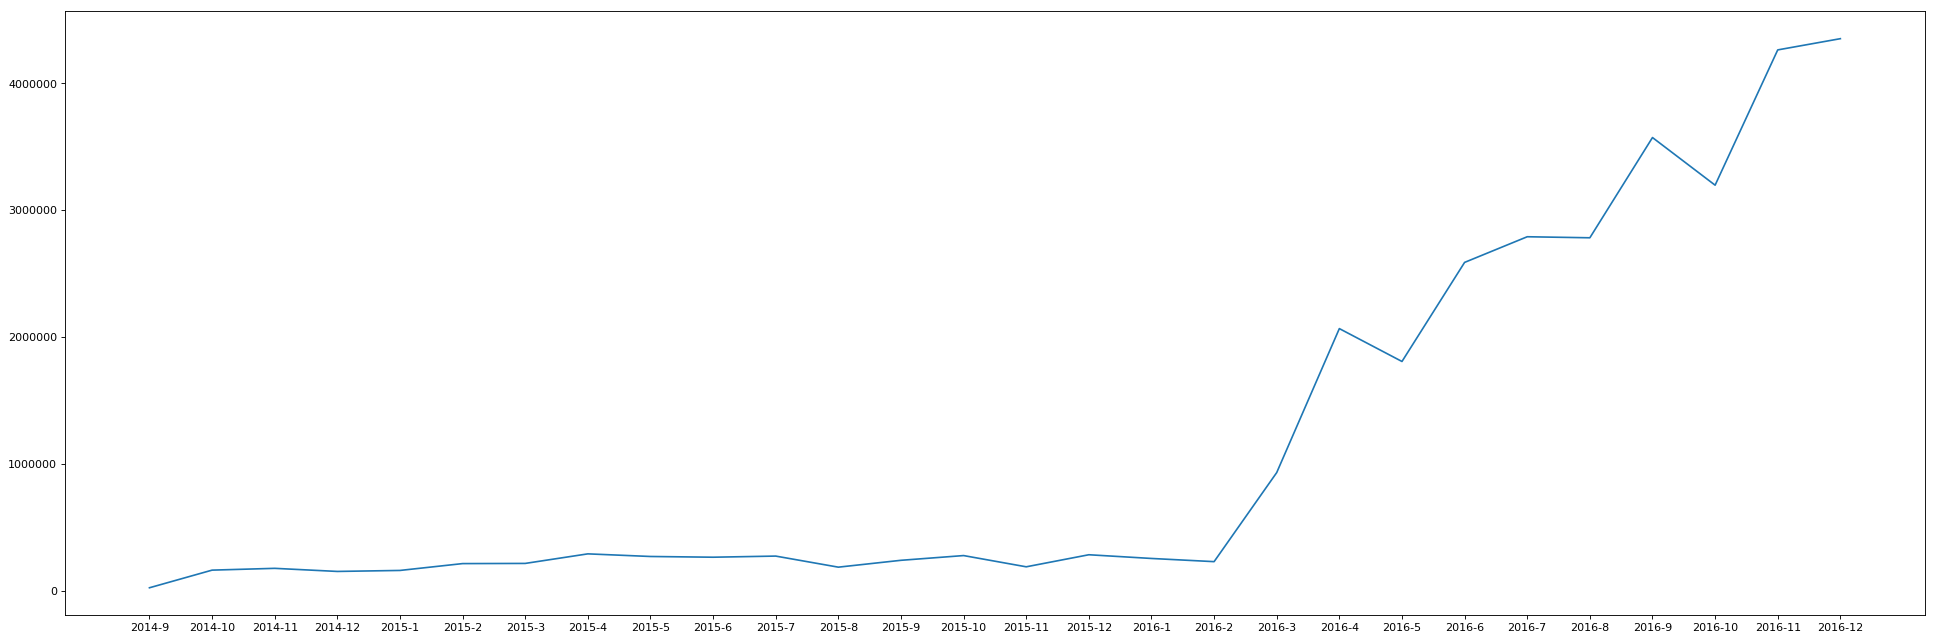

train_en_4


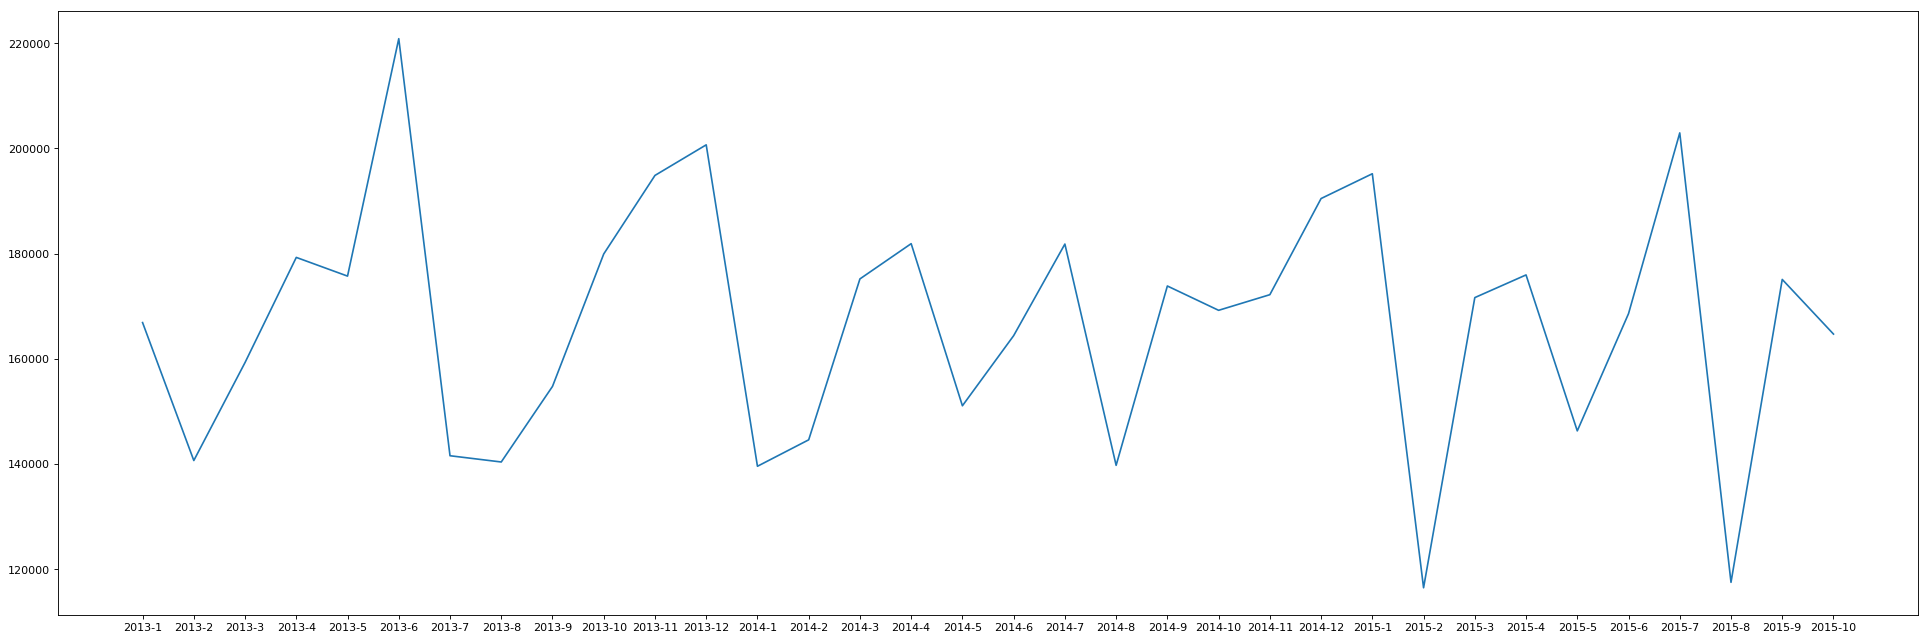

train_en_5


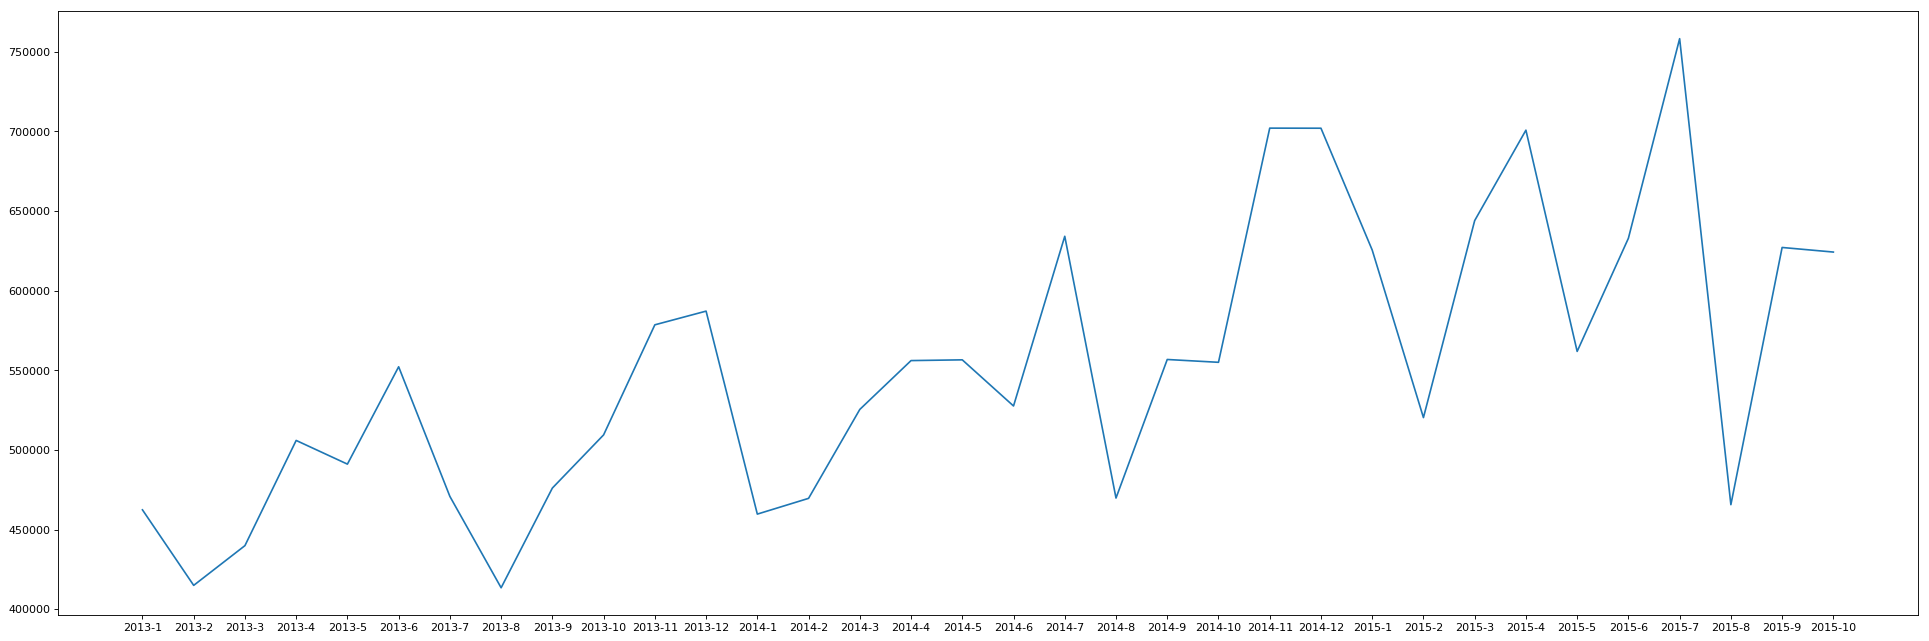

train_be_2


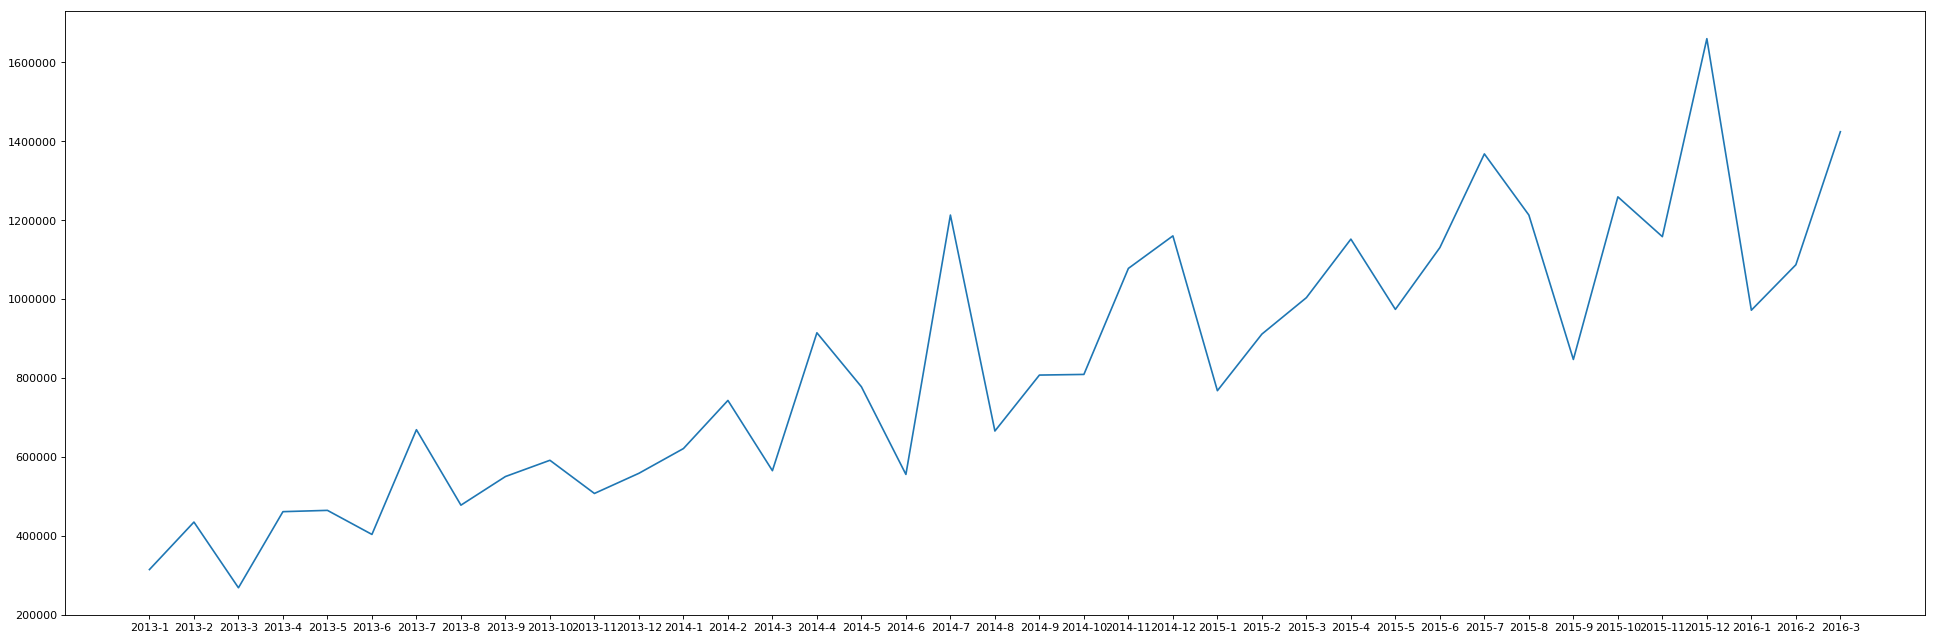

train_de_2


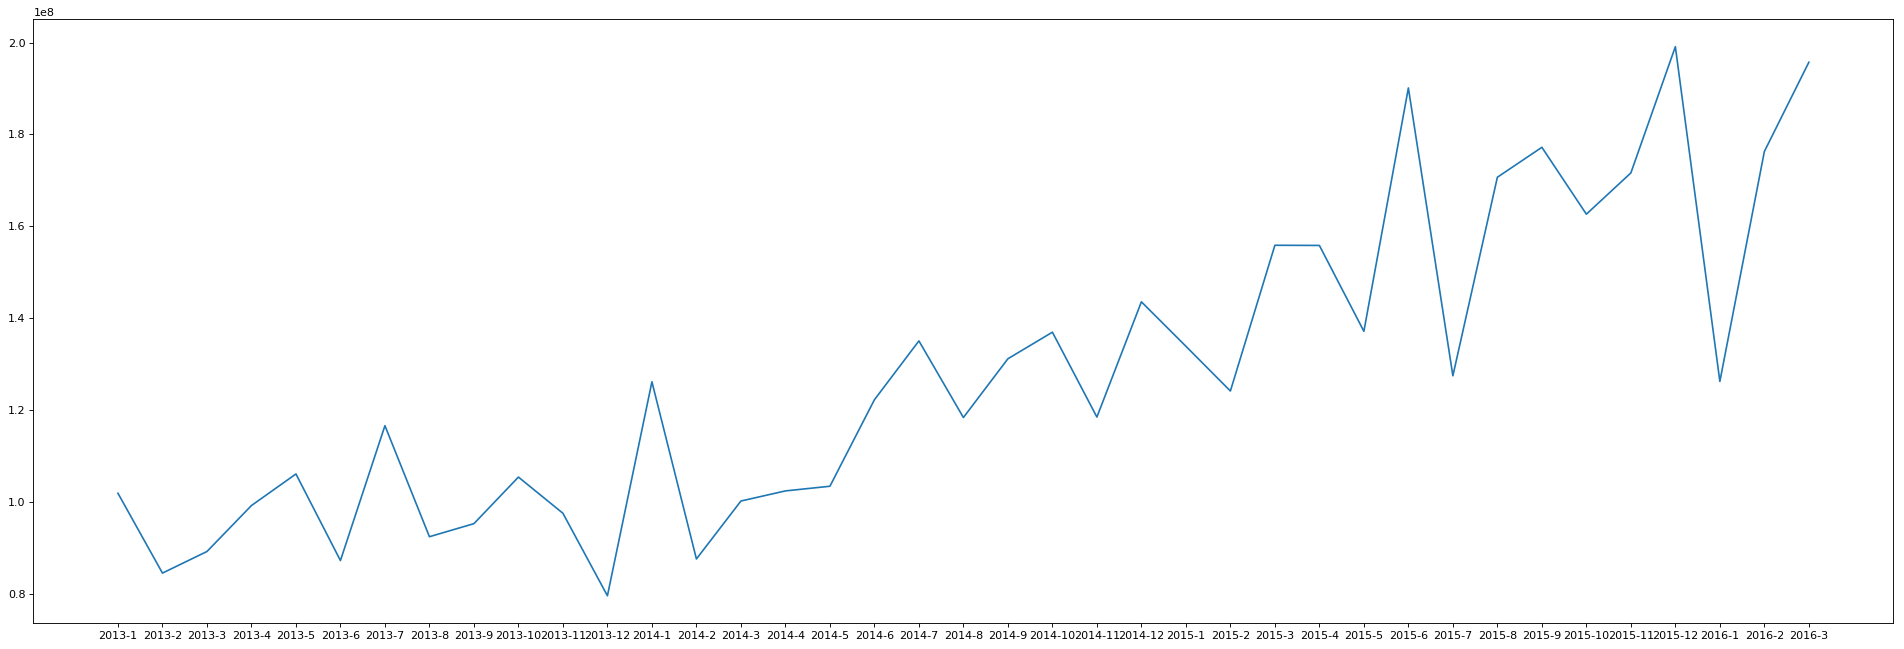

train_fi_4


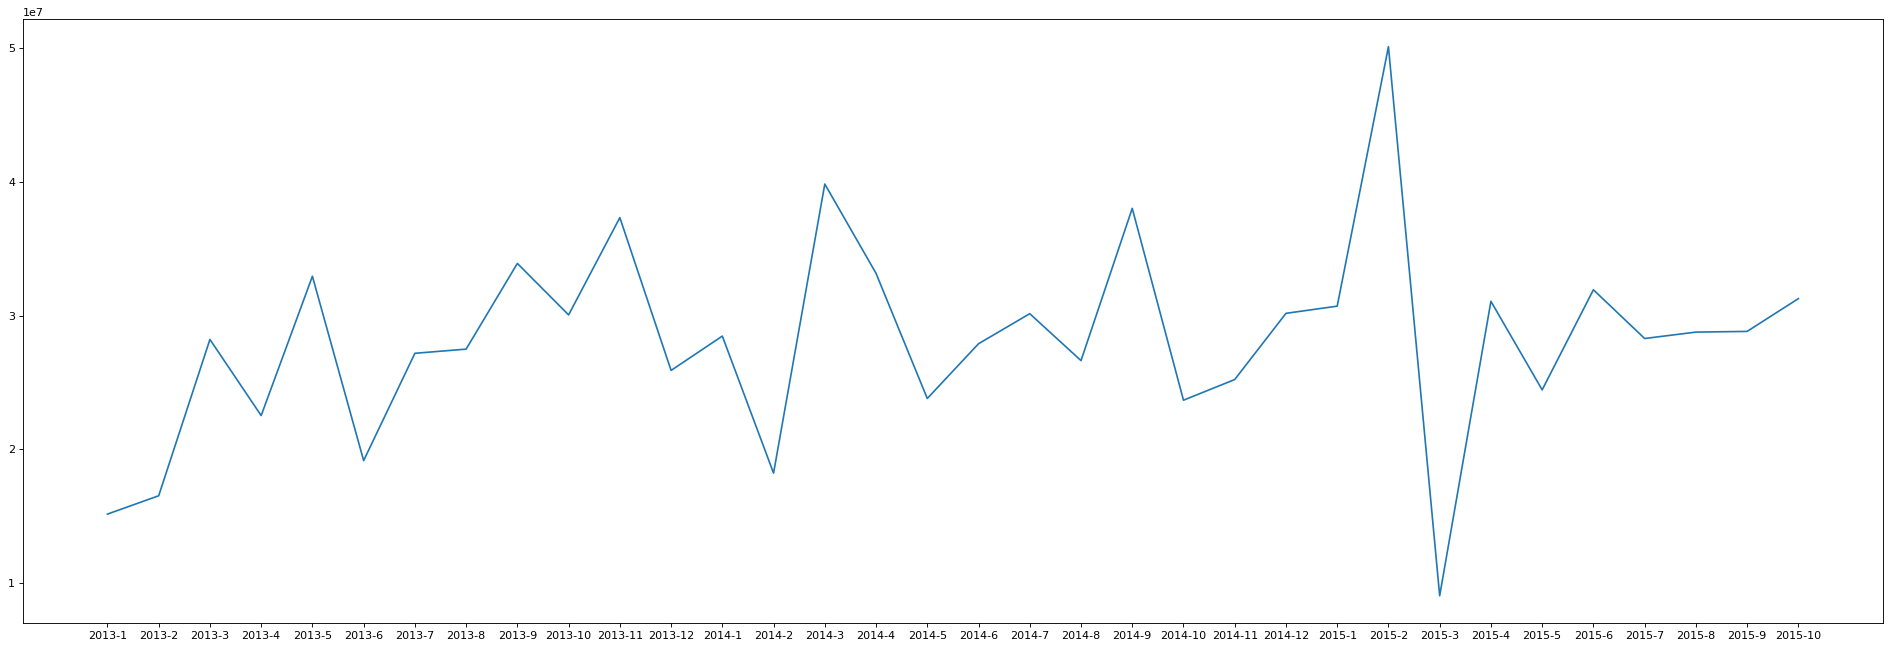

In [24]:
# Time series plot 
for data,name in zip([train_ar_1,train_ar_2,train_ar_3,train_co_1,train_co_2,train_co_3,train_en_4,train_en_5,train_be_2,train_de_2,train_fi_4],['train_ar_1','train_ar_2','train_ar_3','train_co_1','train_co_2','train_co_3','train_en_4','train_en_5','train_be_2','train_de_2','train_fi_4']):
    print(name)
    plt.figure(num=None, figsize=(30, 10), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['Date'],data['Sales'])
    plt.show()

train_ar_1


C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


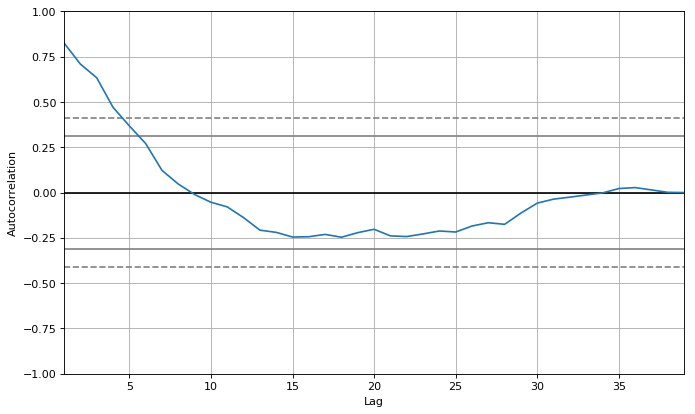

train_ar_2


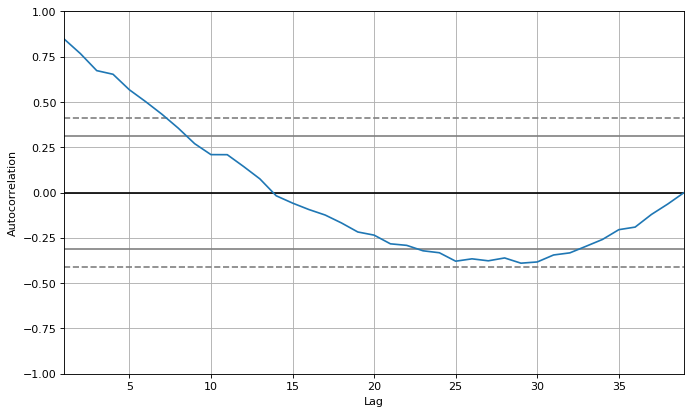

train_ar_3


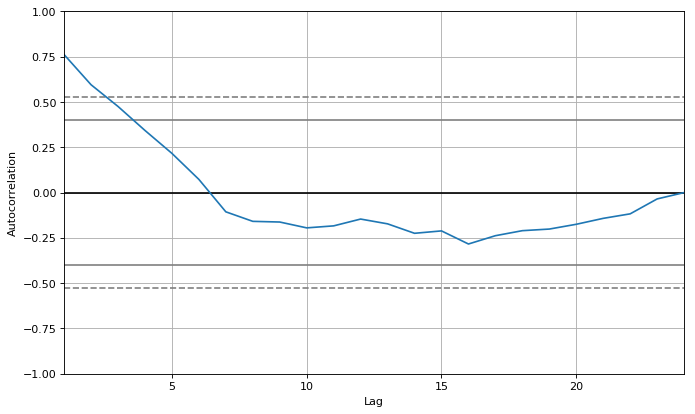

train_co_1


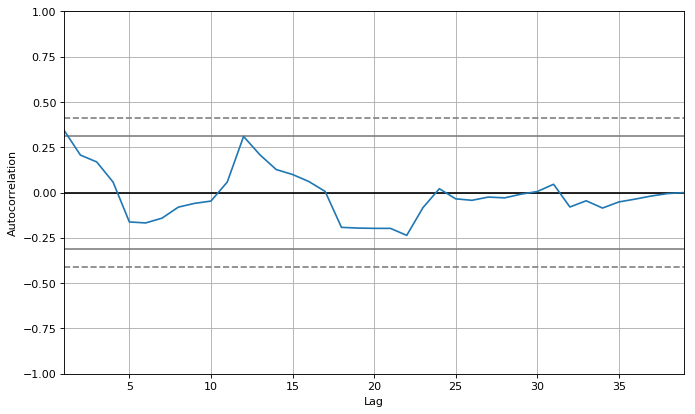

train_co_2


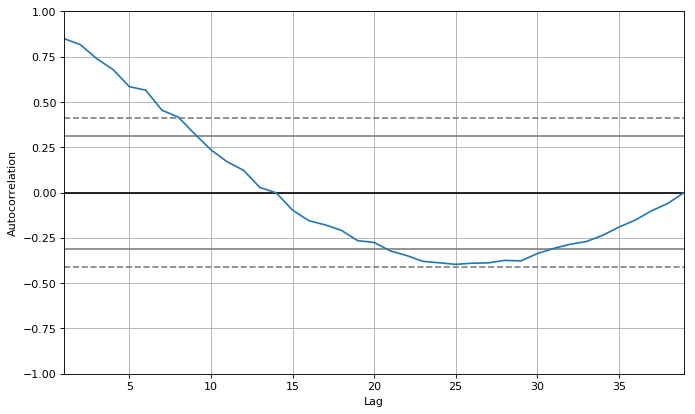

train_co_3


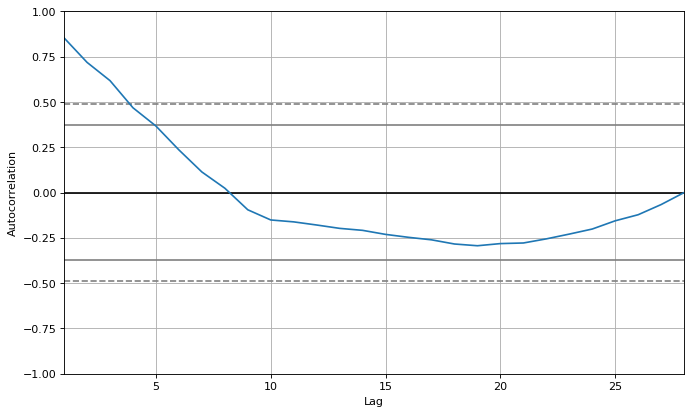

train_en_4


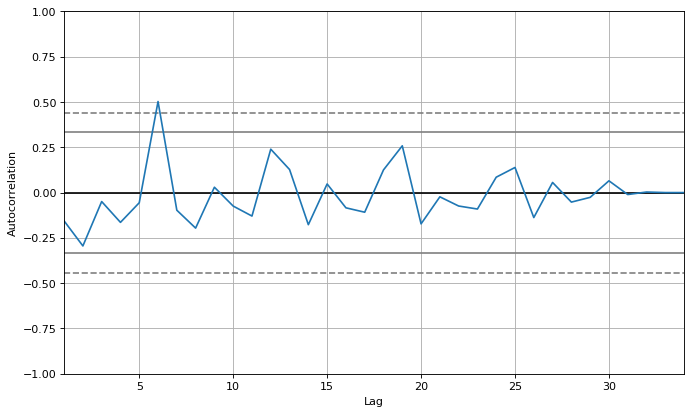

train_en_5


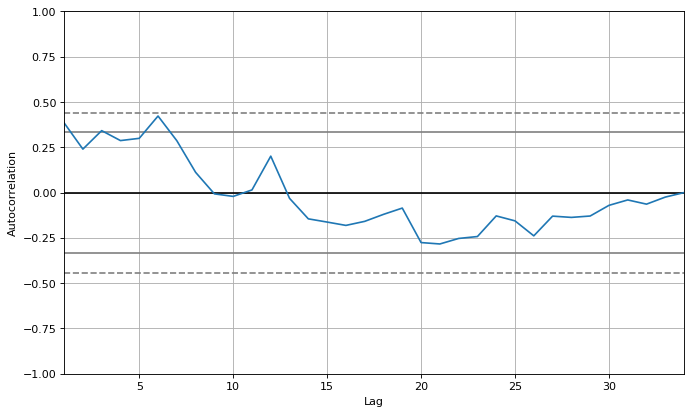

train_be_2


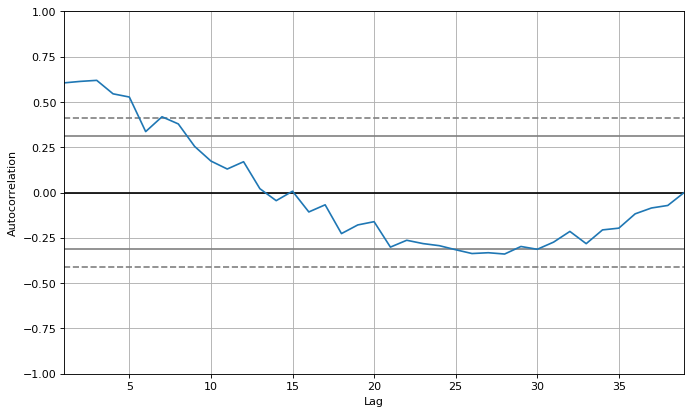

train_de_2


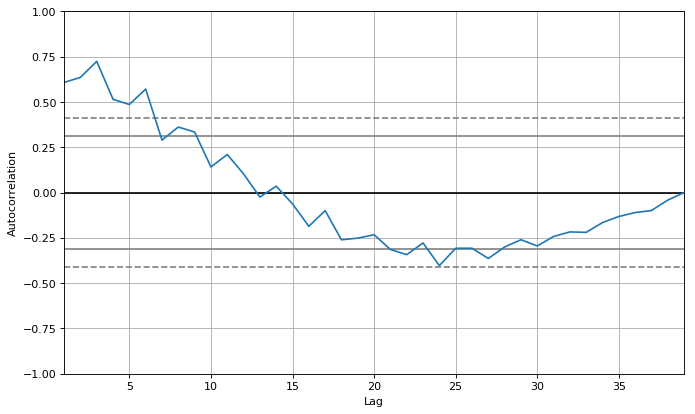

train_fi_4


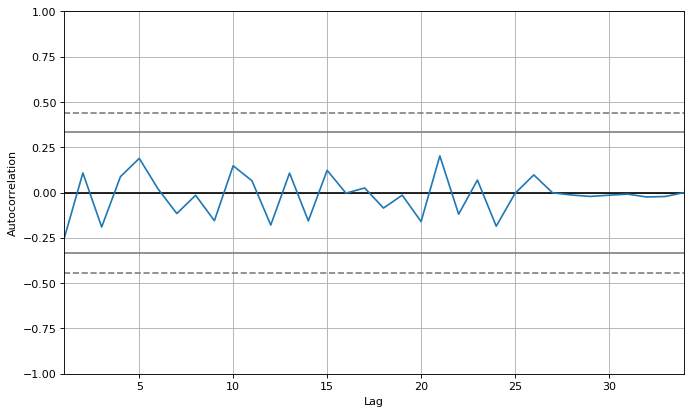

In [25]:
# Autocorrelation
for data,name in zip([train_ar_1,train_ar_2,train_ar_3,train_co_1,train_co_2,train_co_3,train_en_4,train_en_5,train_be_2,train_de_2,train_fi_4],['train_ar_1','train_ar_2','train_ar_3','train_co_1','train_co_2','train_co_3','train_en_4','train_en_5','train_be_2','train_de_2','train_fi_4']):
    print(name)
    plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    from pandas.tools.plotting import autocorrelation_plot
    autocorrelation_plot(data['Sales'])
    plt.show()

<h2>Modelling ARIMA model</h2>

In [26]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

for i,j in zip([train_ar_1,train_ar_2,train_ar_3,train_co_1,train_co_2,train_co_3,train_en_4,train_en_5,train_fi_4],[test_ar_1,test_ar_2,test_ar_3,test_co_1,test_co_2,test_co_3,test_en_4,test_en_5,test_fi_4]):
    info1 = i[['Date','Sales']]
    info2 = j[['Date']]
    trains = info1.iloc[:,1].values
    # tests = test_ar_1.iloc[:,1]
    # size = int(len(X) * 0.66)
    # train, test = X[0:size], X[size:len(X)]
    history = [x for x in trains]
    predictions = list()
    for t in range(len(info2)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    #     obs = test[t]
        history.append(yhat)
#         print(yhat)
    j['Sales'] = list(predictions)
    j['Sales'] = j['Sales'].astype(int)

C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
for i,j in zip([train_be_2,train_de_2],[test_be_2,test_de_2]):
    info1 = i[['Date','Sales']]
    info2 = j[['Date']]
    trains = info1.iloc[:,1].values
    # tests = test_ar_1.iloc[:,1]
    # size = int(len(X) * 0.66)
    # train, test = X[0:size], X[size:len(X)]
    history = [x for x in trains]
    predictions = list()
    for t in range(len(info2)):
        model = ARIMA(history, order=(5,0,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    #     obs = test[t]
        history.append(yhat)
#         print(yhat)
    j['Sales'] = list(predictions)
    j['Sales'] = j['Sales'].astype(int)

In [28]:
final = pd.concat([test_ar_1,test_ar_2,test_ar_3,test_be_2,test_co_1,test_co_2,test_co_3,test_de_2,test_en_4,test_en_5,test_fi_4])

In [29]:
submission_ARIMA = pd.DataFrame({'S_No':final['S_No'],'Year':final['Year'],'Month':final['Month'],'Product_ID':final['Product_ID'],'Country':final['Country'],'Sales':final['Sales']},columns=['S_No','Year', 'Month', 'Product_ID', 'Country', 'Sales'])
submission_ARIMA['Sales'] = submission_ARIMA['Sales'].astype(int)

<h1>Regression Model</h1>

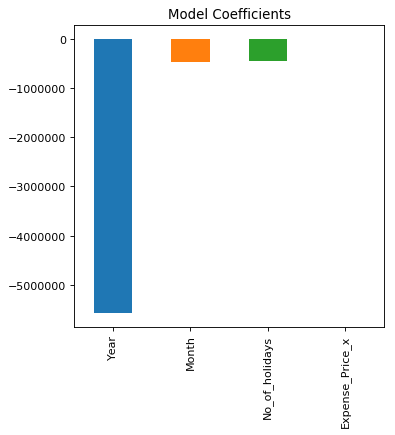

C:\Users\Akhand\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


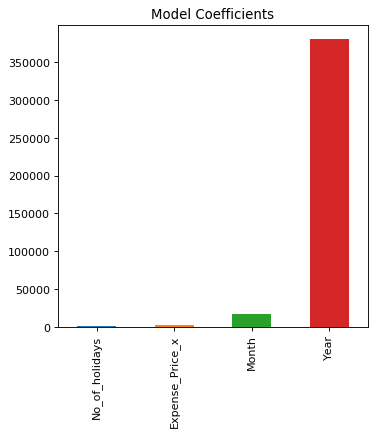

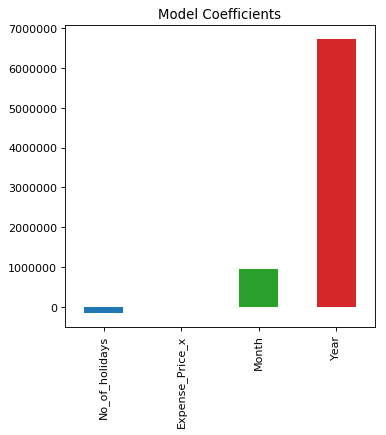

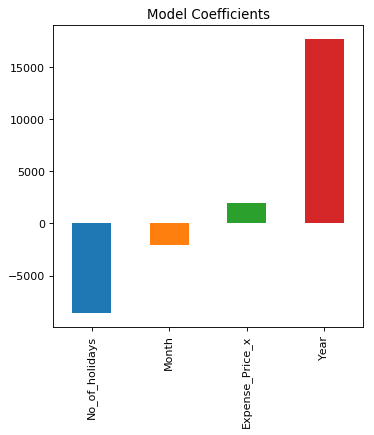

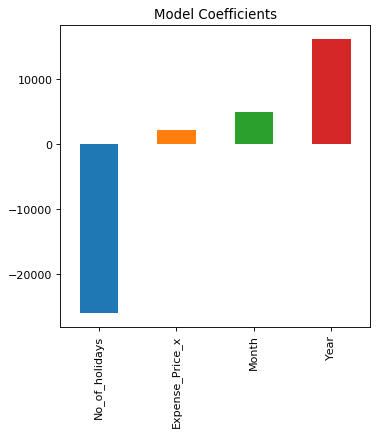

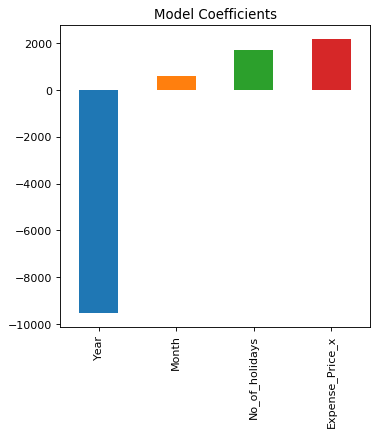

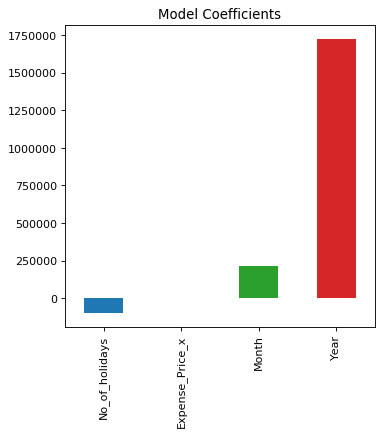

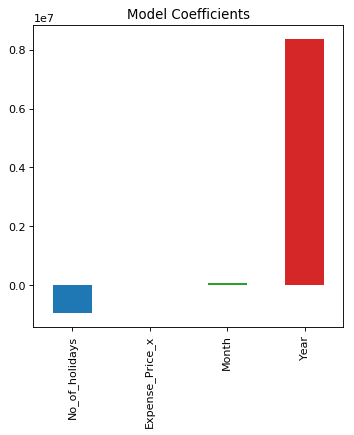

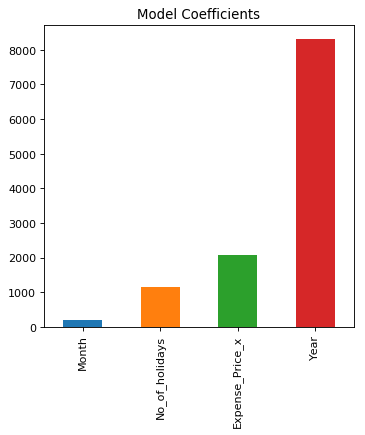

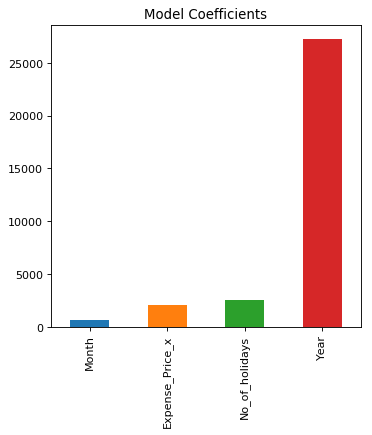

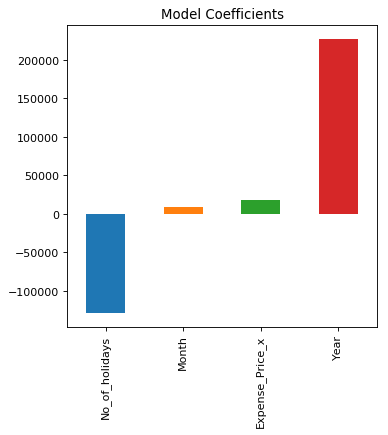

In [30]:
for i,j in zip([train_ar_1,train_ar_2,train_ar_3,train_be_2,train_co_1,train_co_2,train_co_3,train_de_2,train_en_4,train_en_5,train_fi_4],[test_ar_1,test_ar_2,test_ar_3,test_be_2,test_co_1,test_co_2,test_co_3,test_de_2,test_en_4,test_en_5,test_fi_4]):  
    X = i[[cols for cols in i if cols not in ['S_No','Product_ID','Sales','Country','Date']]]
    Y = i[['Sales']]
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X,Y)
    predictors = X.columns
    coef = pd.Series(model.coef_[0],predictors).sort_values()
    plt.figure(num=None, figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
    coef.plot(kind='bar', title='Model Coefficients')
    plt.show()
    pred = model.predict(j[[cols for cols in j if cols not in ['S_No','Product_ID','Sales','Country','Date']]])
    j['Sales'] = pred

In [31]:
final = pd.concat([test_ar_1,test_ar_2,test_ar_3,test_be_2,test_co_1,test_co_2,test_co_3,test_de_2,test_en_4,test_en_5,test_fi_4])

In [32]:
submission_Reg = pd.DataFrame({'S_No':final['S_No'],'Year':final['Year'],'Month':final['Month'],'Product_ID':final['Product_ID'],'Country':final['Country'],'Sales':final['Sales']},columns=['S_No','Year', 'Month', 'Product_ID', 'Country', 'Sales'])
submission_Reg['Sales'] = submission_Reg['Sales'].astype(int)

<h1>Ensembling</h1>

In [33]:
predo1 = submission_ARIMA['Sales']*0.75
predo2 = submission_Reg['Sales']*0.25

In [34]:
predo = pd.Series(predo1) + pd.Series(predo2)

In [35]:
submission_final = pd.DataFrame({'S_No':final['S_No'],'Year':final['Year'],'Month':final['Month'],'Product_ID':final['Product_ID'],'Country':final['Country'],'Sales':predo.values},columns=['S_No','Year', 'Month', 'Product_ID', 'Country', 'Sales'])
submission_final['Sales'] = submission_final['Sales'].astype(int)

In [38]:
submission_final.to_csv('final_submission.csv',index= False)